# LimberJack Target Practice

## Model

In [9]:
using LinearAlgebra
using Turing
using AdvancedHMC
using LimberJack
using CSV
using YAML
using PythonCall
sacc = pyimport("sacc");

using Revise
using MCHMC

[ Info: Precompiling MCHMC [92da4d09-9da0-4f8a-8b31-da41ef0ab6ee]


In [10]:
sacc_path = "/home/jaimerz/PhD/LimberJack.jl/data/FD/cls_FD_covG.fits"
yaml_path = "/home/jaimerz/PhD/LimberJack.jl/data/DESY1/gcgc_gcwl_wlwl.yml"
sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)
meta, files = make_data(sacc_file, yaml_file)

data_vector = meta.data
cov_tot = meta.cov
errs = sqrt.(diag(cov_tot))
fake_data = data_vector ./ errs
fake_cov = Hermitian(cov_tot ./ (errs * errs'));

DESgc__0 DESgc__0 5
DESgc__1 DESgc__1 8
DESgc__2 DESgc__2 10
DESgc__3 DESgc__3 11
DESgc__4 DESgc__4 13
DESgc__0 DESwl__0 5
DESgc__0 DESwl__1 5
DESgc__0 DESwl__2 5
DESgc__0 DESwl__3 5
DESgc__1 DESwl__0 8
DESgc__1 DESwl__1 8
DESgc__1 DESwl__2 8
DESgc__1 DESwl__3 8
DESgc__2 DESwl__0 10
DESgc__2 DESwl__1 10
DESgc__2 DESwl__2 10
DESgc__2 DESwl__3 10
DESgc__3 DESwl__0 11
DESgc__3 DESwl__1 11
DESgc__3 DESwl__2 11
DESgc__3 DESwl__3 11
DESgc__4 DESwl__0 13
DESgc__4 DESwl__1 13
DESgc__4 DESwl__2 13
DESgc__4 DESwl__3 13
DESwl__0 DESwl__0 24
DESwl__0 DESwl__1 24
DESwl__0 DESwl__2 24
DESwl__0 DESwl__3 24
DESwl__1 DESwl__1 24
DESwl__1 DESwl__2 24
DESwl__1 DESwl__3 24
DESwl__2 DESwl__2 24
DESwl__2 DESwl__3 24
DESwl__3 DESwl__3 24


In [11]:
@model function model(data;
                      cov=fake_cov,
                      meta=meta, 
                      files=files)
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.6)
    Ωb ~ Uniform(0.028, 0.065)
    h ~ TruncatedNormal(72, 5, 0.64, 0.82)
    s8 ~ Uniform(0.4, 1.2)
    ns ~ Uniform(0.84, 1.1)

    DESgc__0_b ~ Uniform(0.8, 3.0)
    DESgc__1_b ~ Uniform(0.8, 3.0)
    DESgc__2_b ~ Uniform(0.8, 3.0)
    DESgc__3_b ~ Uniform(0.8, 3.0)
    DESgc__4_b ~ Uniform(0.8, 3.0)
    DESgc__0_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    DESgc__1_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    DESgc__2_dz ~ TruncatedNormal(0.0, 0.006, -0.2, 0.2)
    DESgc__3_dz ~ TruncatedNormal(0.0, 0.01, -0.2, 0.2)
    DESgc__4_dz ~ TruncatedNormal(0.0, 0.01, -0.2, 0.2)
    DESwl__0_dz ~ TruncatedNormal(-0.001, 0.016, -0.2, 0.2)
    DESwl__1_dz ~ TruncatedNormal(-0.019, 0.013, -0.2, 0.2)
    DESwl__2_dz ~ TruncatedNormal(0.009, 0.011, -0.2, 0.2)
    DESwl__3_dz ~ TruncatedNormal(-0.018, 0.022, -0.2, 0.2)
    DESwl__0_m ~ Normal(0.012, 0.023)
    DESwl__1_m ~ Normal(0.012, 0.023)
    DESwl__2_m ~ Normal(0.012, 0.023)
    DESwl__3_m ~ Normal(0.012, 0.023)
    A_IA ~ Uniform(-5, 5) 
    alpha_IA ~ Uniform(-5, 5)

    nuisances = Dict("DESgc__0_b" => DESgc__0_b,
                     "DESgc__1_b" => DESgc__1_b,
                     "DESgc__2_b" => DESgc__2_b,
                     "DESgc__3_b" => DESgc__3_b,
                     "DESgc__4_b" => DESgc__4_b,
                     "DESgc__0_dz" => DESgc__0_dz,
                     "DESgc__1_dz" => DESgc__1_dz,
                     "DESgc__2_dz" => DESgc__2_dz,
                     "DESgc__3_dz" => DESgc__3_dz,
                     "DESgc__4_dz" => DESgc__4_dz,
                     "DESwl__0_dz" => DESwl__0_dz,
                     "DESwl__1_dz" => DESwl__1_dz,
                     "DESwl__2_dz" => DESwl__2_dz,
                     "DESwl__3_dz" => DESwl__3_dz,
                     "DESwl__0_m" => DESwl__0_m,
                     "DESwl__1_m" => DESwl__1_m,
                     "DESwl__2_m" => DESwl__2_m,
                     "DESwl__3_m" => DESwl__3_m,
                     "A_IA" => A_IA,
                     "alpha_IA" => alpha_IA,)

    cosmology = Cosmology(Ωm, Ωb, h, ns, s8,
                          tk_mode="EisHu",
                          Pk_mode="Halofit")

    theory = Theory(cosmology, meta, files; Nuisances=nuisances)
    data ~ MvNormal(theory ./ errs, cov)
end

model (generic function with 2 methods)

In [12]:
stat_model = model(fake_data)

DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}(model, (data = [3.214096950162085, 4.70756721223778, 6.415689628953242, 5.828388701788672, 8.493679322382144, 2.9304058751712, 7.998464834088993, 5.1210836387672565, 8.932453735970117, 8.407292870179436  …  1.8338144344899103, 3.6747343455612156, 2.7292480563019765, 2.265947203686935, 3.1513497907284673, 2.887098863974196, 0.7659895057386662, 2.8855449419318098, 2.3446896354956963, 1.6352516474328562], cov = [1.0 -0.289532718133784 … -4.320136350638793e-5 -4.4205040697944595e-5; -0.289532718133784 0.9999999999999998 … -9.461726942265441e-5 -9.845166181745778e-5; … ; -4.320136350638793e-5 -9.461726942265441e-5 … 0.9999999999999998 0.0033632257724296594; -4.4205040697944595e-5 -9.84516618174577

## Sampling

In [14]:
target = TuringTarget(stat_model);

LoadError: UndefVarError: `cubic_spline_interpolation` not defined

In [6]:
eps=0.005
L=sqrt(20)
mchmc = Sampler(eps=eps, L=L, integrator="MN")

LoadError: UndefVarError: `Sampler` not defined

In [11]:
samples_mchmc = Sample(mchmc, target; num_steps=10000);

LoadError: UndefVarError: `target` not defined

In [98]:
samples_mchmc = samples_mchmc[2000:end]

8002-element Vector{Vector{Float64}}:
 [0.12554358712728442, 0.9919170610886492]
 [0.12319779248930104, 0.9963238189200965]
 [0.12171251106765242, 1.0010875623585804]
 [0.12082395154855315, 1.0059975333398101]
 [0.12057504441289461, 1.010982067639457]
 [0.12131286344773692, 1.0159199601641133]
 [0.12280831188959712, 1.0206861207864422]
 [0.12514331979144658, 1.0251042716074255]
 [0.12816240782525776, 1.0290878542496964]
 [0.13136983280113235, 1.0329225284363854]
 [0.13480102904212635, 1.0365588473497507]
 [0.13861375997847533, 1.039792640122339]
 [0.14275529414670668, 1.042591879143739]
 ⋮
 [0.17741380143532282, 0.968877658963651]
 [0.17852960867857195, 0.973747920635926]
 [0.1790809532521344, 0.9787105134188931]
 [0.1792127566314048, 0.983698185262652]
 [0.17827029361112698, 0.9885896876827096]
 [0.17555905888317427, 0.9927565852122875]
 [0.17184744747791225, 0.9960618429906218]
 [0.16702337995874972, 0.9972953306420679]
 [0.16203874458101308, 0.9970917289684483]
 [0.15721327337569452

## Plotting

In [85]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

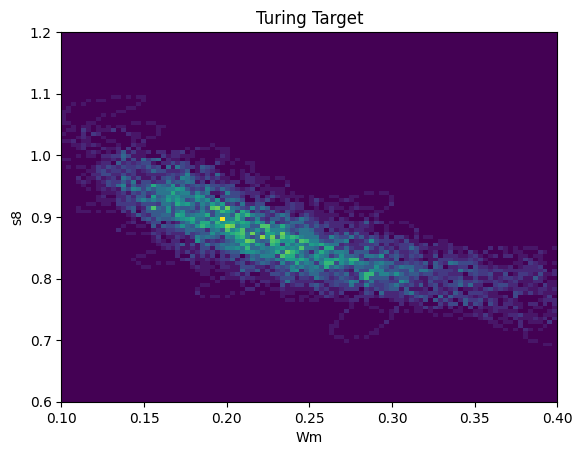

In [86]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Turing Target");

## NUTS

In [99]:
@time samples_hmc = sample(stat_model, NUTS(500, 0.65),
                  10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


  2.321411 seconds (8.05 M allocations: 6.237 GiB, 19.40% gc time)


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 2.26 seconds
Compute duration  = 2.26 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2333    0.0604     0.0006    0.0012   2702.3852    1.0007    ⋯
          σ8    0.8668    0.0596     0.0006    0.0010   2961.9687    1.0012    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [88]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

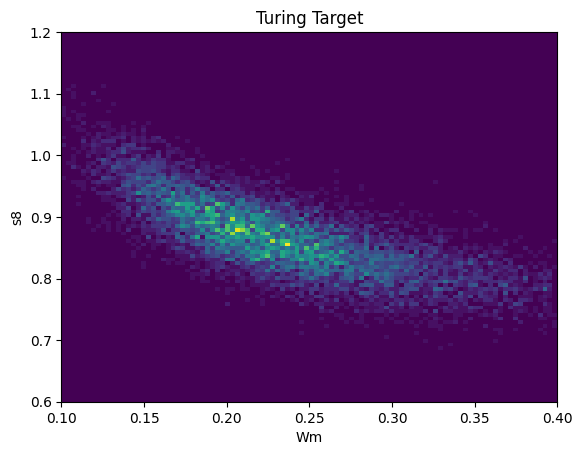

In [89]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Turing Target");

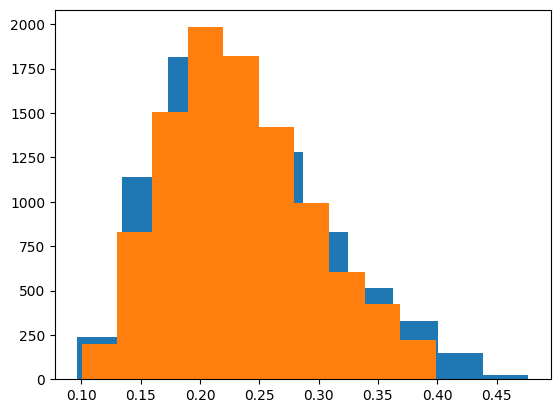

([196.0, 827.0, 1504.0, 1983.0, 1820.0, 1424.0, 995.0, 606.0, 422.0, 223.0], [0.10011538396676943, 0.12997272691551753, 0.15983006986426565, 0.18968741281301377, 0.21954475576176186, 0.24940209871051, 0.2792594416592581, 0.3091167846080062, 0.3389741275567543, 0.3688314705055024, 0.39868881345425056], (PyObject <matplotlib.patches.Rectangle object at 0x7f3b46eec490>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b46edc220>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b46eec8b0>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b46eecaf0>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b46eeccd0>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b46eeceb0>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b46eecfa0>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b46e4b2b0>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b46e4b490>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b46e4b670>))

In [90]:
plt.hist(Wms_mchmc)
plt.hist(Wms_hmc)

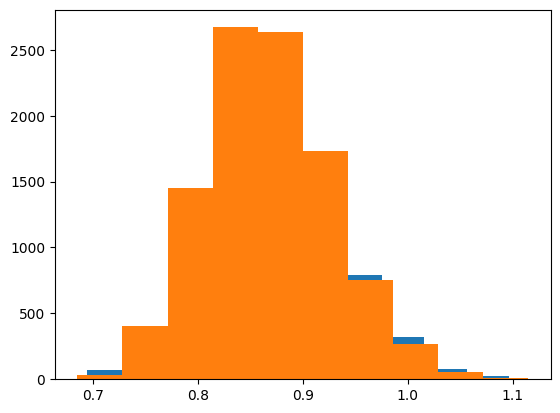

([29.0, 402.0, 1452.0, 2671.0, 2638.0, 1729.0, 750.0, 264.0, 53.0, 12.0], [0.6851745091383957, 0.7281292743987308, 0.7710840396590658, 0.814038804919401, 0.856993570179736, 0.899948335440071, 0.9429031007004061, 0.9858578659607411, 1.0288126312210761, 1.0717673964814112, 1.1147221617417462], (PyObject <matplotlib.patches.Rectangle object at 0x7f3b4d9bc0a0>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b4da4dc10>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b4da2c160>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b4da2cfa0>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b4d9cdb50>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b4d9cdd90>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b4d9b1340>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b4d9b1c10>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b4d9b15e0>, PyObject <matplotlib.patches.Rectangle object at 0x7f3b4d9d9a30>))

In [91]:
plt.hist(s8s_mchmc)
plt.hist(s8s_hmc)

In [92]:
using AverageShiftedHistograms, Plots

In [93]:
Wm_hmc_ker = ash(Wms_hmc; m=30)
s8_hmc_ker = ash(s8s_hmc; m=30)
Wm_mchmc_ker = ash(Wms_mchmc; m=30)
s8_mchmc_ker = ash(s8s_mchmc; m=30);

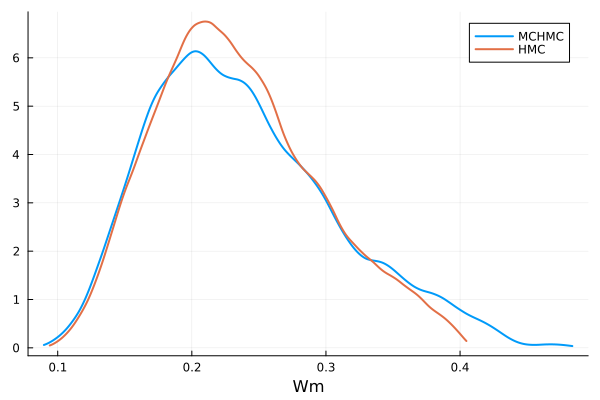

In [94]:
Plots.plot(Wm_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(Wm_hmc_ker; hist=false, label="HMC", xlabel="Wm")

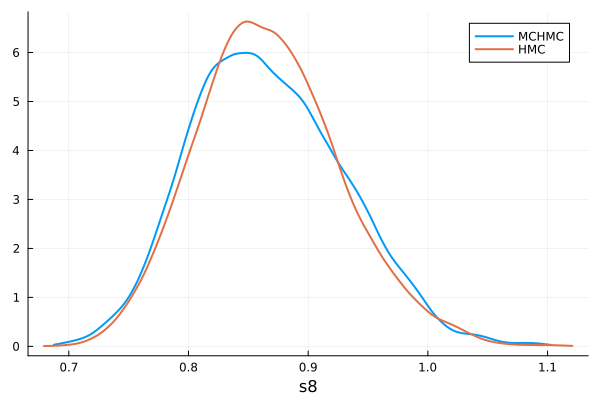

In [95]:
Plots.plot(s8_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(s8_hmc_ker; hist=false, label="HMC",  xlabel="s8")

In [96]:
plot(o; hist=false)

LoadError: UndefVarError: `plot` not defined

## Self-tuning

In [12]:
mchmc = Sampler()
println(string("L = ", mchmc.settings.L, ", eps = ", mchmc.settings.eps))
# This should start self-tuning    

L = 0.0, eps = 0.0


In [13]:
mchmc.settings.tune_samples

1000

In [14]:
samples = Sample(mchmc, target; num_steps=10000, dialog=true);

Self-tuning hyperparameters
Hyperparameter tuning (first stage)


LoadError: UndefVarError: `samples` not defined